In [1]:
import sqlite3 as sql
import numpy as np

In [4]:
# Connecting to the Kaggle Pitchfork Database 
db = sql.connect('../../data/pitchfork.sqlite')
cursor = db.cursor()

artist_dict = {}
artist_lookup = {}

#An artist class for holding the information
class Artist:
    def __init__(self, name):
        self.name = name
        self.reviews = []
        self.genres = []
        self.scores = []
    def add_review(self, review):
        self.reviews.append(review)
    def add_genre(self, genre):
        self.genres.append(genre)
    def add_score(self, score):
        self.scores.append(score)
    def __str__(self):
        return self.name
 

cursor.execute('select reviews.reviewid, artist, genre, score from reviews join genres on genres.reviewid = reviews.reviewid')
for row in cursor:
    if row[1] not in artist_dict:
        artist_dict[row[1]] = Artist(row[1])
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])
        artist_lookup[row[1]] = len(artist_lookup)
    else: 
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])

In [32]:
genres = {}
genre_lookup = {}
scores = {}
cursor.execute('select distinct genre from genres')
for row in cursor:
    genre_lookup[len(genre_lookup)] = row[0] 
    genres[row[0]] = []
    
for i in range(11):
    scores[i] = []
    
for artist in artist_dict: 
    artist_lookup
    for genre in artist_dict[artist].genres:
        genres[genre].append(artist_lookup[artist])
    mean_score = np.mean(artist_dict[artist].scores)
    scores[round(mean_score)].append(artist_lookup[artist])

In [46]:
def gen_batch(genres, scores, size, bias):
    xs = np.ndarray(shape=(size), dtype=np.int32)
    ys = np.ndarray(shape=(size, 1), dtype=np.int32)
    for idx in range(size):
        b = np.random.randint(10)
        if b < bias:
            genre = np.random.randint(len(genres))
            g1 = np.random.randint(len(genres[genre_lookup[genre]]))
            g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            while g1 == g2:
                g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            xs[idx] = genres[genre_lookup[genre]][g1]
            ys[idx][0] = genres[genre_lookup[genre]][g2]
        else:
            score = np.random.randint(len(scores))
            s1 = np.random.randint(len(scores[score]))
            s2 = np.random.randint(len(scores[score]))
            while s1 == s2:
                s2 = np.random.randint(len(scores[score]))
            xs[idx] = scores[score][s1]
            ys[idx][0] = scores[score][s2]
    return xs, ys

artist_decode = dict(zip(artist_lookup.values(), artist_lookup.keys()))

In [47]:
xs, ys = gen_batch(genres, scores, 64, 6)
print(ys)

[[3746]
 [7814]
 [5982]
 [5385]
 [4949]
 [5921]
 [3665]
 [2661]
 [4408]
 [4400]
 [5702]
 [8449]
 [4099]
 [4028]
 [3137]
 [6511]
 [3574]
 [7920]
 [ 147]
 [4964]
 [8133]
 [1684]
 [1374]
 [7411]
 [7831]
 [8513]
 [3847]
 [ 332]
 [4812]
 [1477]
 [4271]
 [4153]
 [6824]
 [   5]
 [2639]
 [4048]
 [8472]
 [6521]
 [1525]
 [1845]
 [5209]
 [8002]
 [4893]
 [5919]
 [1362]
 [ 100]
 [6883]
 [2136]
 [6487]
 [7284]
 [ 950]
 [1943]
 [5873]
 [5351]
 [7950]
 [6699]
 [ 365]
 [6425]
 [   5]
 [4506]
 [ 880]
 [4563]
 [2309]
 [3984]]


In [48]:
#Before we dive in we need to declare some variables
vocabulary_size = len(artist_lookup)
#How big we want our final vectors to be
embedding_size = 64
#The number of training samples passed per epoch
batch_size = 64
#Number of negative samples to use in NCE [see below]
num_sampled = 16

In [66]:
#BAND2VEC - Tensorflow Time!
import tensorflow as tf
import math 

graph = tf.Graph()

with graph.as_default():
    #Defining variables and functions in a scope is good practice
    with tf.name_scope('inputs'):
        #Tensorflow Placeholders are the mouths of the neural network - they will constantly be fed new information
        training_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        training_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    #Using the CPU
    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            #The embeddings - variables are maintained across runs and need to be initialised with a shape and type
            #Each row is a band represented by a vector of length 'embedding_size'
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            #Like passing muliple indices to a numpy array we get the vectors quickly with this function
            embed = tf.nn.embedding_lookup(embeddings, training_inputs)
        
        with tf.name_scope('weights'):
            #Like embeddings we initialise our weights and also...
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
            
        with tf.name_scope('biases'):
            #...our biases
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            
    with tf.name_scope('loss'):
        #Finally our loss function - see below for an explanation of the Noise Contrastive Estimation Approach
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=training_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

In [67]:
#Running our Neural Network!
#First we init the session

iterations = 100000

with tf.Session(graph=graph) as sess:
    #We run the initialize all global variables operation
    sess.run(tf.global_variables_initializer())
    average_loss = 0.0
    #For all of the iterations
    for index in range(iterations):
        #Generate a batch
        ti, tl = gen_batch(genres, scores, batch_size, 6)
        feed_dict = {training_inputs: ti, training_labels: tl}
        #Run the NN! Notice the feed dict feeding our placeholders from before
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        #Some metrics so we can see how we're doing
        average_loss += loss_val
        if (index + 1) % 2000 == 0:
            print('Average loss at step', index + 1, average_loss / (index + 1))
            
    final_embeddings = embeddings.eval()

Average loss at step 2000 32.0357041576
Average loss at step 4000 22.4317537278
Average loss at step 6000 17.2577046571
Average loss at step 8000 14.1501901102
Average loss at step 10000 12.0763101191
Average loss at step 12000 10.5832788947
Average loss at step 14000 9.46769161684
Average loss at step 16000 8.60290928816
Average loss at step 18000 7.91798107533
Average loss at step 20000 7.35743659998
Average loss at step 22000 6.8878729088
Average loss at step 24000 6.48843365943
Average loss at step 26000 6.1487060513
Average loss at step 28000 5.85335203903
Average loss at step 30000 5.59343291543
Average loss at step 32000 5.36340010983
Average loss at step 34000 5.15800762206
Average loss at step 36000 4.9730344883
Average loss at step 38000 4.80567119013
Average loss at step 40000 4.65370077761
Average loss at step 42000 4.51547628218
Average loss at step 44000 4.3880136283
Average loss at step 46000 4.27078944506
Average loss at step 48000 4.1628119491
Average loss at step 5000

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.217803
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.197295
[t-SNE] Error after 500 iterations: 2.434611


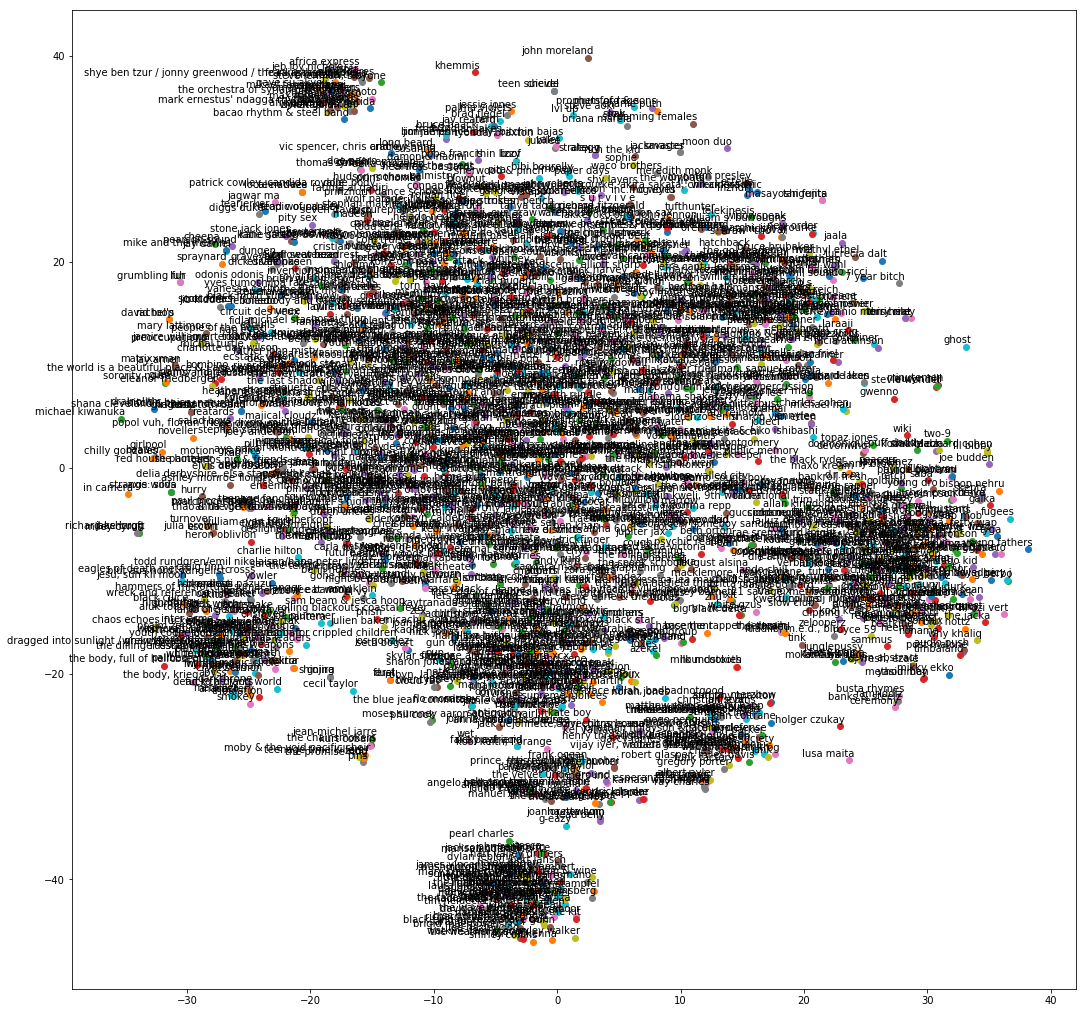

In [71]:
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, verbose=1, init='pca', n_iter=500, method='exact')
    plot_only = 2000
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

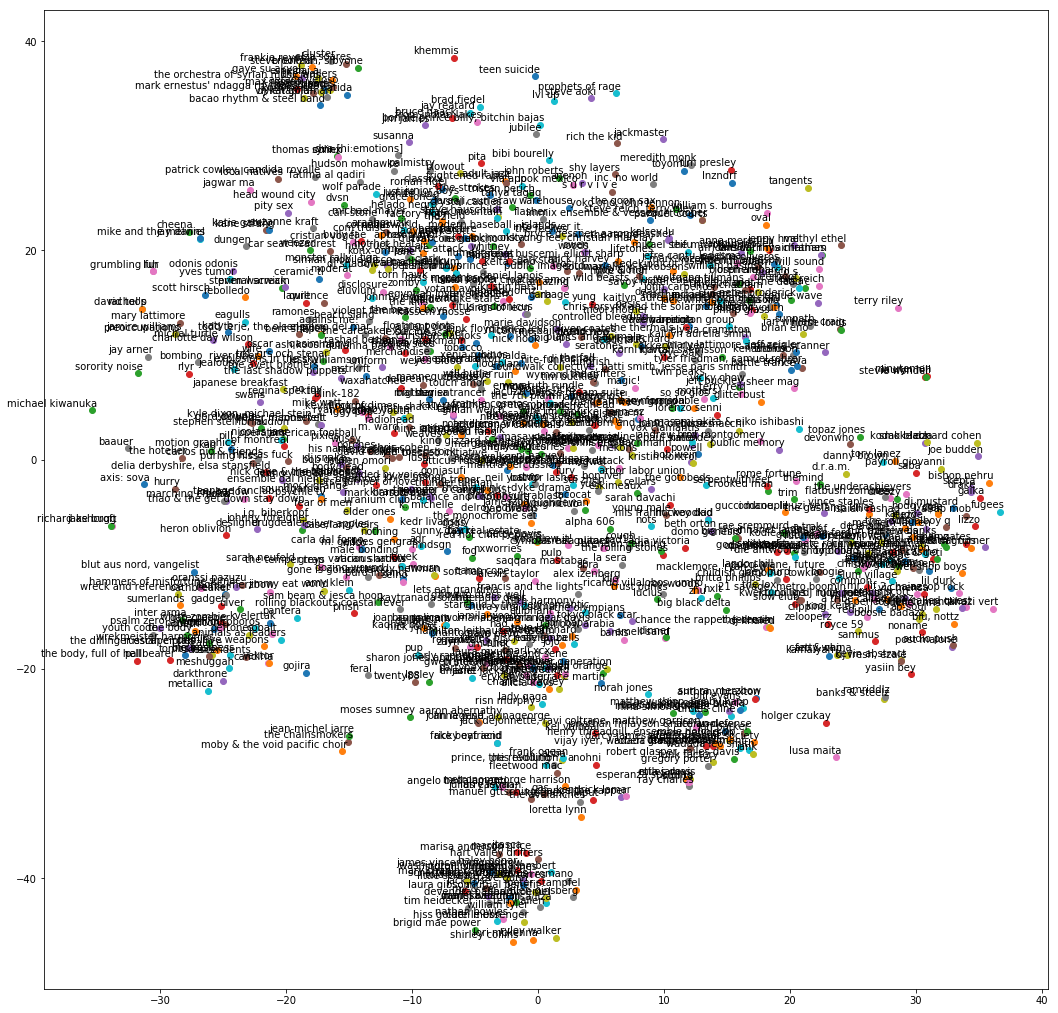

In [76]:
from tempfile import gettempdir
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.show()

labels = []
for i in range(1000):
    if artist_decode[i] != 'joey bada$$':
        labels.append(artist_decode[i])
plot_with_labels(low_dim_embs, labels, './other.png')

In [96]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def top_n_similar_words(word, n):
    index = artist_lookup[word]
    vector_representation = low_dim_embs[index]
    csim = cosine_similarity([vector_representation], low_dim_embs)
    esim = euclidean_distances([vector_representation], low_dim_embs)
    cindices = np.argsort(csim)
    eindices = np.argsort(esim)
    top_n = []
    for id1, id2 in zip(cindices[0][-n:], eindices[0][:n]) :
        top_n.append((artist_decode[id1], artist_decode[id2]))
    return top_n

tn = top_n_similar_words('loretta lynn', 5)
tn2 = top_n_similar_words('brigid mae power', 5)

In [99]:
for b1, b2 in tn:
    print(b2, 'Mean Score:' , np.mean(artist_dict[b2].scores), 'Genres:', artist_dict[b2].genres)
print('-----------------')
for b1, b2 in tn2:
    print(b2, 'Mean Score:' , np.mean(artist_dict[b2].scores), 'Genres:', artist_dict[b2].genres)

loretta lynn Mean Score: 8.65 Genres: ['folk/country', 'folk/country']
joanna newsom Mean Score: 8.76 Genres: ['folk/country', 'folk/country', 'folk/country', 'folk/country', 'folk/country']
lead belly Mean Score: 9.0 Genres: ['folk/country']
the avalanches Mean Score: 9.0 Genres: ['electronic', 'electronic']
the staple singers Mean Score: 8.7 Genres: ['rock']
-----------------
brigid mae power Mean Score: 7.5 Genres: ['folk/country']
richard thompson Mean Score: 7.52 Genres: ['folk/country', 'folk/country', 'folk/country', 'folk/country', 'folk/country']
lee hazlewood Mean Score: 7.84 Genres: ['folk/country', 'folk/country', 'folk/country', 'folk/country', 'folk/country']
cate le bon Mean Score: 7.575 Genres: ['folk/country', 'folk/country', 'folk/country', 'folk/country']
sarah bethe nelson Mean Score: 7.4 Genres: ['folk/country']


In [108]:
an_electronic_folk_band = low_dim_embs[artist_lookup['loretta lynn']] + low_dim_embs[artist_lookup['chance the rapper']]

In [116]:
def find_closest(band_embedding):
    for idx, lde in enumerate(low_dim_embs):
        closest = 10
        _id = 0
        difference = np.mean(band_embedding) - np.mean(lde)
        print(difference)
        if difference > closest:
            closests = difference
            _id = idx
    return artist_decode[_id]

efb = find_closest(an_electronic_folk_band)
print(efb, 'Mean Score:' , np.mean(artist_dict[efb].scores), 'Genres:', artist_dict[efb].genres)

-34.6963
-6.32206
-20.6187
-14.0755
-26.8675
-17.6626
-35.9503
-33.4372
-44.6744
-31.0996
-40.5068
-39.3268
-26.1616
-32.7069
-35.6949
-43.0278
-29.1981
-19.8235
-29.3108
-8.85543
-26.2792
-19.4565
-46.5265
-35.6587
-7.47177
-33.1061
-27.6864
-18.5113
-36.0066
-10.9982
-37.853
-42.5595
-33.8433
-32.8313
-40.6627
-23.2456
-35.694
-25.4482
-32.9614
-19.4027
-37.6493
-20.2831
-45.8251
-25.714
-35.619
-20.198
-28.278
-21.0955
-41.4483
-32.1922
-35.0093
-36.8823
-39.5595
-42.5343
-31.4024
-12.3831
-34.8942
-37.3654
-25.9111
-26.7374
-17.8007
-33.4882
-40.335
-28.561
-36.966
-30.6021
-25.4384
-31.8996
-30.7157
-8.92493
-19.5075
-13.2462
-45.5634
-21.4069
-22.1349
-36.586
-18.696
-26.7477
-36.9576
-25.2721
-28.4631
-16.5137
-36.9747
-21.1186
-46.0658
-33.306
-25.2365
-30.2796
-18.8217
-29.8122
-45.8556
-35.5168
-33.7663
-31.5515
-22.8137
-19.9555
-35.9006
-48.3269
-18.5075
-40.5829
-38.3736
-21.0325
-49.2297
-31.252
-39.7429
-33.9726
-28.6963
-24.746
-36.0592
-3.99361
-32.4883
-22.5597
-6.137